In [ ]:
!pip install google-cloud-aiplatform --upgrade --user --quiet
!pip install langchain==0.0.229 chromadb==0.3.26 pydantic==1.10.8 typing-inspect==0.8.0 typing_extensions==4.5.0 pandas datasets google-api-python-client pypdf faiss-cpu transformers config --upgrade --user --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.6/123.6 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 51.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 42.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 54.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 51.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 65.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 kB 9.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 964.5/964.5 

In [ ]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 50.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.8 MB/s eta 0:00:00
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 7.0.0
    Uninstalling importlib-metadata-7.0.0:
      Successfully uninstalled importlib-metadata-7.0.0


In [ ]:
from google.colab import auth as google_auth
google_auth.authenticate_user()
PROJECT_ID = "iron-decorator-297513" # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}
from google.cloud import aiplatform
from langchain.llms import VertexAI
import vertexai
aiplatform.init(project=PROJECT_ID, location=LOCATION)
vertexai.init(project=PROJECT_ID, location=LOCATION)


In [ ]:
from langchain.agents import create_pandas_dataframe_agent
import pandas as pd
df1 = pd.read_csv("/content/data1.csv")
df2 = pd.read_csv("/content/data2.csv")
df3 = pd.read_csv("/content/data3.csv")
import streamlit as st
import matplotlib.pyplot as plt

In [ ]:
LLM = VertexAI( model_name="text-bison@001",max_output_tokens=512,top_k=40)
agent = create_pandas_dataframe_agent(llm=LLM,df=[df1,df2,df3])
from langchain.llms import VertexAI

In [ ]:
def ask_agent(agent, query):
    """
    Query an agent and return the response as a string.

    Args:
        agent: The agent to query.
        query: The query to ask the agent.

    Returns:
        The response from the agent as a string.
    """
    # Prepare the prompt with query guidelines and formatting
    prompt = (
        """
        Let's decode the way to respond to the queries. The responses depend on the type of information requested in the query.



        1. If the query requires a table, format your answer like this:
           {"table": {"columns": ["column1", "column2", ...], "data": [[value1, value2, ...], [value1, value2, ...], ...]}}

        2. For a bar chart, respond like this:
           {"bar": {"columns": ["A", "B", "C", ...], "data": [25, 24, 10, ...]}}

        3. If a line chart is more appropriate, your reply should look like this:
           {"line": {"columns": ["A", "B", "C", ...], "data": [25, 24, 10, ...]}}

        Note: We only accommodate two types of charts: "bar" and "line".

        4. For a plain question that doesn't need a chart or table, your response should be:
           {"answer": "Your answer goes here"}

        For example:
           {"answer": "The Product with the highest Orders is '15143Exfo'"}

        5. If the answer is not known or available, respond with:
           {"answer": "I do not know."}

        Return all output as a string. Remember to encase all strings in the "columns" list and data list in double quotes.
        For example: {"columns": ["Products", "Orders"], "data": [["51993Masc", 191], ["49631Foun", 152]]}

        Now, let's tackle the query step by step. Here's the query for you to work on:
        """
        + query
    )

    # Run the prompt through the agent and capture the response.
    response = agent.run(prompt)

    # Return the response converted to a string.
    return (response)

def write_answer(response_dict):
  print(response_dict)
  if "answer" in response_dict:
    print(response_dict["answer"])
    st.write(response_dict["answer"])
  if "bar" in response_dict:
        data = response_dict["bar"]
        try:
          df_data = {
          col: [x[i] if isinstance(x, list) else x for x in data['data']] for i, col in enumerate(data['columns'])}
          df = pd.DataFrame(df_data)
          #df.set_index("VehicleNumber", inplace=True)
          x_column = df.columns[0]
          y_column = df.columns[1]
          df.plot(kind='bar', x=x_column, y=y_column, color='blue', legend=False)


        except ValueError:
          print(f"Couldn't create DataFrame from data: {data}")
  if "line" in response_dict:
        data = response_dict["line"]
        try:
          df_data = {
          col: [x[i] if isinstance(x, list) else x for x in data['data']] for i, col in enumerate(data['columns'])}
          df = pd.DataFrame(df_data)
          df.set_index("VehicleNumber", inplace=True)
          st.line_chart(df)
        except ValueError:
          print(f"Couldn't create DataFrame from data: {data}")


{'bar': {'columns': ['vehicle_number', 'capacitor'], 'data': [3000, 2500, 4000, 1500, 3500]}}


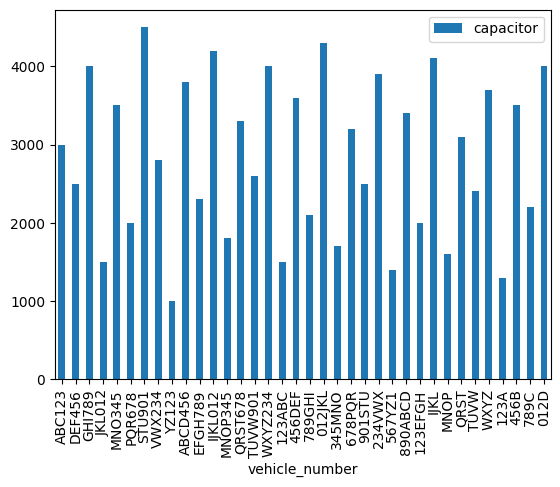

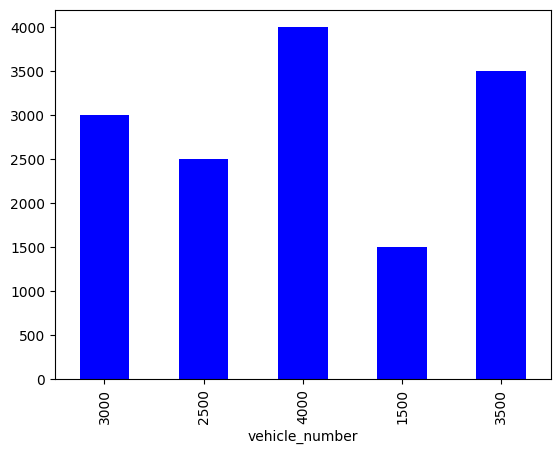

In [106]:
import json
query = "Create a barchart for all the records of the  vehicle number and capacitor "
response = ask_agent(agent=agent, query=query)
#response
#print(response)
dictionar = eval(response)
final = write_answer(dictionar)
#type(dictionar)

#dictionary = json.loads(json.dumps(response).replace("\\", '"'))
#print(type(response))
#print(dictionary)

#print(final)

In [ ]:
query = "Create a barchart for all the records of the  vehicle number and temperature "
response = ask_agent(agent=agent, query=query)

In [ ]:
print(response)

Agent stopped due to iteration limit or time limit.


In [ ]:
a = {"bar": {"columns": ["vehicle_number", "temperature"], "data": [['ABC123', 32], ['DEF456', 28], ['GHI789', 37], ['JKL012', 25], ['MNO345', 34]]}}
b = json.dumps(a)
print(b)

{"bar": {"columns": ["vehicle_number", "temperature"], "data": [["ABC123", 32], ["DEF456", 28], ["GHI789", 37], ["JKL012", 25], ["MNO345", 34]]}}


In [ ]:
import json
query = "Give the distribution of the temperature "
response = ask_agent(agent=agent, query=query)
#decoded_response = decode_response(response)
print(decoded_response)

NameError: ignored

In [ ]:
data = {
    'columns': ['A', 'B', 'C'],
    'data': [[1, 2, 3], 4, [5, 6, 7]]
}
df_data = {
col: [x[i] if isinstance(x, list) else x for x in data['data']]
for i, col in enumerate(data['columns'])}

In [ ]:
df_data

{'A': [1, 4, 5], 'B': [2, 4, 6], 'C': [3, 4, 7]}

In [ ]:
import pandas as pd
df = pd.DataFrame(df_data)
df

,A,B,C
0,1,2,3
1,4,4,4
2,5,6,7


In [ ]:
d = {"bar": {"columns": ["vehicle_number", "temperature"], "data": [['ABC123', 32], ['DEF456', 28], ['GHI789', 37], ['JKL012', 25], ['MNO345', 34]]}}
type(d)
#data = d["bar"]
#data

dict

In [ ]:
df_data = {col: [x[i] if isinstance(x, list) else x for x in data['data']] for i, col in enumerate(data['columns'])}

In [ ]:
df_data

{'vehicle_number': ['ABC123', 'DEF456', 'GHI789', 'JKL012', 'MNO345'],
 'temperature': [32, 28, 37, 25, 34]}

In [ ]:
df = pd.DataFrame(df_data)

In [ ]:
df

,vehicle_number,temperature
0,ABC123,32
1,DEF456,28
2,GHI789,37
3,JKL012,25
4,MNO345,34


In [ ]:
{"bar": {"columns": ["vehicle_number", "temperature"], "data": [['ABC123', 32], ['DEF456', 28], ['GHI789', 37], ['JKL012', 25], ['MNO345', 34]]}}
{"bar": {"columns": ["vehicle_number", "temperature"], "data": [['ABC123', 32], ['DEF456', 28], ['GHI789', 37], ['JKL012', 25], ['MNO345', 34]]}}

In [ ]:
type(response)

str

In [ ]:
a = {"bar": {"columns": ["vehicle_number", "temperature"], "data": [['ABC123', 32], ['DEF456', 28], ['GHI789', 37], ['JKL012', 25], ['MNO345', 34]]}}
type(a)

dict

In [ ]:
response

{'columns': ['vehicle_number', 'temperature'],
 'data': [['ABC123', 32],
  ['DEF456', 28],
  ['GHI789', 37],
  ['JKL012', 25],
  ['MNO345', 34]]}

In [ ]:
response = response.replace("\"", "")

In [ ]:
response = data

In [ ]:
result_dict = {data['bar']['columns'][i]: [row[i] for row in data['bar']['data']] for i in range(len(data['bar']['columns']))}

KeyError: ignored

In [ ]:
import ast
res = eval(response)
type(res)


NameError: ignored

In [ ]:
response = '{"bar": {"columns": ["vehicle_number", "temperature"], "data": [[\'ABC123\', 32], [\'DEF456\', 28], [\'GHI789\', 37], [\'JKL012\', 25], [\'MNO345\', 34]]}}'
cleaned_string = response.replace('\\\\', '\\')
#cleaned_string
cleaned_string1 = cleaned_string.replace(r'\\', '')
cleaned_string1


'{"bar": {"columns": ["vehicle_number", "temperature"], "data": [[\'ABC123\', 32], [\'DEF456\', 28], [\'GHI789\', 37], [\'JKL012\', 25], [\'MNO345\', 34]]}}'

In [ ]:
cleaned_string = eval(response)


In [ ]:
type(cleaned_string)
data = cleaned_string["bar"]
df_data = {col: [x[i] if isinstance(x, list) else x for x in data['data']] for i, col in enumerate(data['columns'])}
df = pd.DataFrame(df_data)

In [ ]:
data

{'columns': ['vehicle_number', 'temperature'],
 'data': [['ABC123', 32],
  ['DEF456', 28],
  ['GHI789', 37],
  ['JKL012', 25],
  ['MNO345', 34]]}

In [ ]:
df = pd.DataFrame(cleaned_string)

In [ ]:
df

,vehicle_number,temperature
0,ABC123,32
1,DEF456,28
2,GHI789,37
3,JKL012,25
4,MNO345,34
